In [1]:
from parameters_general import *
from parameters_eigen import *
from functions import *
import numpy as np 
import pickle
import matplotlib.pyplot as plt

In [12]:
import matplotlib as mpl
import colorsys
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgb
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

# Funktion zum Reduzieren der Sättigung
def desaturate_color(color, factor=0.9):
    # Konvertiere die Farbe in den RGB-Farbraum
    r, g, b = to_rgb(color)
    # Konvertiere die Farbe in den HSV-Farbraum
    h, s, v = colorsys.rgb_to_hsv(r, g, b)
    # Reduziere die Sättigung
    s *= factor
    # Konvertiere die Farbe zurück in den RGB-Farbraum
    desaturated_color = colorsys.hsv_to_rgb(h, s, v)
    return desaturated_color

jet_map = plt.get_cmap('plasma')
new_colors = jet_map(np.linspace(0, 1, 5))
new_color =[desaturate_color(new_colors[i]) for i in range(5)]
SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 14
LW = 2

lowred = desaturate_color('red')
lowblue = desaturate_color('blue')

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

linestyles =['-',':', '--','-.']#, ''] 
dashlist = [(5,2),(2,2),(1,2,4,2),(1,1), (2,5), (1,2,2,2), (3,2,2)]
#colorlist =['firebrick', 'green'] 
mpl.rcParams['mathtext.default'] = 'regular'

In [39]:
qlist = (np.linspace(1.5/700, 1.5, 700))**2/(1.5)
rel_str = 'False'
#E_1 =[0.037,0.11,0.221,0.55]
#E_1 =[0.037,0.11,0.221, 0.333]
E_1 =[0.0001, 3,6, 12, 20]
#E_1 =[0.0001, 3, 6, 9, 12, 15, 20, 30, 40]
Qdim = '700'
n_distr =[]
spectra =[]  
for i, field in enumerate(E_1):
    with open(r"results/eigen/Qdim=700_Qmax=1.5_power{}_true_E_conversion_pf_corr=0.15_n_wells1_z2500320.0_reflectionsFalse_quadratic_grid_final_n_distr.pickle".format(field), 'rb') as output_file:
        n_dis = pickle.load(output_file)    
    n_distr.append(n_dis)


/usr/local/python3/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/python3/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


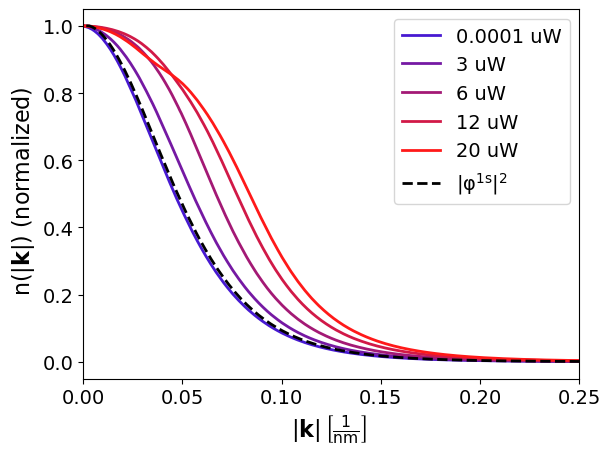

In [40]:
for i in range(len(n_distr)):
    if True:#i == 0:
        plt.plot(qlist[:400] , np.real(n_distr[i][:400])/max(np.real(n_distr[i][:400])), label = str(E_1[i])+' uW',  linewidth = 2, linestyle = '-', color = colorFader(lowblue,lowred,(i+1)/(len(E_1))))
    elif i == len(n_distr)-1:
        plt.plot(qlist[:400] , np.real(n_distr[i][:400])/max(np.real(n_distr[i][:400])), label = str(E_1[i])+' uW',  linewidth = 2, linestyle = '-', color = colorFader(lowblue,lowred,(i+1)/(len(E_1))))
    else:
        plt.plot(qlist[:400] , np.real(n_distr[i][:400])/max(np.real(n_distr[i][:400])), linewidth = 2, linestyle = '-', color = colorFader(lowblue,lowred,(i+1)/(len(E_1))))
plt.plot(qlist_w[:300], (np.array(EVs[:300,0])/max(EVs[:300,0]))**2, 'k--', linewidth = 2, label = r'$|\varphi^{1s}|^2$')
plt.xlim(0, 0.25)
plt.xlabel(r'$|\mathbf{k}|\, \left[ \frac{1}{nm}\right]   $ ', fontsize = 16)
plt.ylabel(r' $n\left(|\mathbf{k}|\right) $ (normalized)' , fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14) 
plt.legend(fontsize = 14)
plt.savefig('Distribution_weak_pulses.pdf',bbox_inches = 'tight')

In [4]:
@jit(nopython = True)
def wannier_matrix(qlist, philist, m_eff, epsilon_s_stat, d): 
    """
    Generates the matrix describing the eigenvalue problem for the Wannier equation

    Parameters:
    -----------
    qlist : list or array-like
        A list of values representing the momentum grid in the q-dimension, assumed equidistant.
    philist : list or array-like
        A list of values for the angular component (phi), also assumed equidistant.
    m_eff : float
        The effective mass of the particle, e.g. averaged effective electron and hole mass.
    epsilon_s_stat: static dielectric constant of background material
    d: effective quantum well thickness
    Returns:
    --------
    matrix : ndarray of complex numbers
        A complex matrix of shape (len(qlist), len(qlist)) where each element represents the 
        contribution to the Wannier eigenvalue problem at the respective (q, q') values.
    
    Notes:
    ------
    - The matrix includes both kinetic and potential energy contributions.
    - Assumes that qlist and philist are equidistant grids for efficient computation.
    - The potential V is applied radially based on the relative distance in momentum space, 
      calculated from qlist and philist.
    """
    Qdim = len(qlist)
    phidim = len(philist)
    dQ = qlist[1]-qlist[0] 
    dphi = philist[1]-philist[0]
    matrix = np.zeros((Qdim,Qdim), dtype='complex_')
    for n in range(Qdim):
        for j in range(Qdim):
            if n == j:
                matrix[n][j] += hbar * hbar * 0.5 / m_eff * qlist[n]**2
            # every matrix element has this contribution
            phi_integral = 0    
            for i in range(phidim):
                # round is added to avoid negative values
                q_absolute = np.sqrt(np.round(qlist[n]**2+qlist[j]**2-2*qlist[n]*qlist[j]*np.cos(philist[i]),10))
                if q_absolute > dQ:
                    phi_integral += V(q_absolute, epsilon_s_stat, d)      
            phi_integral *= dQ*qlist[j]*dphi
            phi_integral /= (2*np.pi)**2
            matrix[n][j] -= phi_integral    
    return matrix


def solve(matrix):
    """
    Diagonalizes a given matrix and returns its eigenvalues and eigenvectors.

    Parameters:
    -----------
    matrix : ndarray
        A square matrix (n x n) to be diagonalized, with complex or real values.

    Returns:
    --------
    EWs : ndarray
        An array of eigenvalues of the matrix.
    EVs : ndarray
        A matrix (n x n) where each column is an eigenvector corresponding to the respective 
        eigenvalue in `EWs`.
    
    Notes:
    ------
    - The function outputs the number of eigenvalues and eigenvectors found.
    - The matrix diagonalization is done using `numpy.linalg.eig`.
    """
    EWs, EVs = np.linalg.eig(matrix)
    #print("Es wurden {EW} Eigenwerte und {EV} Eigenvektoren gefunden.".format(EW=len(EWs), EV=len(EVs)))
    negativcounter = 0
    for EW in EWs:
        if EW.real < 0:
            negativcounter += 1
    #print("davon haben {neg} negativen Realteil".format(neg=negativcounter))
    return EWs, EVs

@jit(nopython = True)
def normalize(EVs, qlist):
    """
    Normalizes the eigenvectors of a system based on a given momentum grid.

    Parameters:
    -----------
    EVs : ndarray
        A matrix where each column represents an eigenvector that will be normalized.
    qlist : list or array-like
        A list of momentum values in the q-dimension, assumed to be equidistant.

    Returns:
    --------
    EVs : ndarray
        The matrix of eigenvectors, with each column normalized according to the qlist grid.

    Notes:
    ------
    - The function assumes an equidistant momentum grid (`qlist`) to compute a consistent normalization.
    - Each eigenvector is scaled by the square root of its total area, using a weighting factor of 
      q*dQ/(2*pi), where `dQ` is the spacing between adjacent points in `qlist`.
    - Eigenvectors with a zero normalization area are left unchanged.
    """
    dQ = qlist[1]-qlist[0] 
    for i in range(len(EVs)):
        area = 0.
        for j in range(len(EVs)):
            q = qlist[j] 
            area += q*dQ/2/np.pi*np.conjugate(EVs[j,i])*EVs[j,i]
        for j in range(len(EVs)):
            if area != 0:
                EVs[j,i]/= np.sqrt(area)
    return EVs


def sort(EWs,EVs):
    """
    Sorts eigenvalues and their corresponding eigenvectors in ascending order of eigenvalues.

    Parameters:
    -----------
    EWs : ndarray
        An array of eigenvalues.
    EVs : ndarray
        A matrix where each column is an eigenvector corresponding to the respective eigenvalue in `EWs`.

    Returns:
    --------
    EWs : ndarray
        The sorted array of eigenvalues in ascending order.
    EVs : ndarray
        The matrix of eigenvectors, rearranged so that each column corresponds to the sorted eigenvalues.

    Notes:
    ------
    - Sorting is performed in-place, rearranging `EWs` and `EVs` so that the eigenvalues in `EWs`
      are in ascending order, with corresponding columns in `EVs`.
    - Assumes that `EWs` and `EVs` have compatible shapes, where each column of `EVs` is an eigenvector.
    """
    Qdim = len(EWs)
    for i in range(Qdim):
        for j in range(i,Qdim):
            if (EWs[j]<EWs[i]):
                EWs[[i,j]] = EWs[[j,i]]
                EVs[:,[i, j]] = EVs[:,[j, i]]
    return EWs, EVs


def solve_(matrix, qlist):
    """
    Wrapper function to solve, normalize, and sort the eigenvalues and eigenvectors of a given matrix.

    This function performs the following steps:
    1. Diagonalizes the matrix to find its eigenvalues and eigenvectors.
    2. Normalizes the eigenvectors.
    3. Sorts the eigenvalues in ascending order and arranges eigenvectors accordingly.

    Parameters:
    -----------
    matrix : ndarray
        The matrix to be diagonalized, normalized, and sorted.
    qlist : np.array
        momentum grid for eigenvector normalization

    Returns:
    --------
    EWs : ndarray
        The sorted array of eigenvalues.
    EVs : ndarray
        The matrix of normalized and sorted eigenvectors, where each column corresponds to an eigenvalue in `EWs`.

    Notes:
    ------
    - This wrapper function utilizes `solve`, `normalize`, and `sort` to process the eigensystem in a streamlined manner.
    """
    EWs, EVs = solve(matrix)
    EVs = normalize(EVs, qlist)
    EWs, EVs = sort(EWs,EVs)
    return EWs, EVs

def phi0(EVs,mu, qlist):
    """
    Calculates the exciton orbital amplitude for a specific eigenstate `mu` at `r = 0`.

    Parameters:
    -----------
    EVs : ndarray
        A matrix of eigenvectors, where each column represents an eigenstate, with each row corresponding 
        to a specific momentum value in `qlist`.
    mu : int
        The index of the eigenstate (column in `EVs`) for which the exciton orbital value at `r = 0` 
        is calculated.
    qlist : list or array-like
        A list of momentum values in the q-dimension, assumed to be equidistant.

    Returns:
    --------
    phi0 : float
        The calculated exciton orbital amplitude for the specified eigenstate `mu` at `r = 0`.

    Notes:
    ------
    - The function uses a weighted sum over momentum values in `qlist` to compute `phi0`, which represents
      the amplitude of the exciton orbital at the origin (`r = 0`) in the specified eigenstate.
    - Assumes `qlist` has equidistant spacing, calculated as `dQ = qlist[1] - qlist[0]`.
    - The calculation includes a factor of `q * dQ / (2 * pi)` for each momentum component.
    """

    phi0 = 0.
    Qdim = len(qlist)
    dQ = qlist[1]-qlist[0]
    for j in range(Qdim):
        q = qlist[j] 
        phi0 += q*dQ/2/np.pi*EVs[j,mu]    
    return phi0   

def chi(EWs,EVs, mu, omega, omega_0, d_cv, gamma, n_ref, qlist):
    return -d_cv**2 * np.abs(phi0(EVs,mu, qlist))**2*(1/(hbar*((omega)-EWs[mu]/hbar + 1j*gamma + 1j* d_cv**2 * np.abs(phi0(EVs,mu, qlist))**2 *omega_0/(2*hbar*c*n_ref*epsilon_0))))/epsilon_0#+1/(hbar*(-omega-E_G/hbar-EWs[mu]/hbar - 1j*gamma - 1j*d_cv**2 * np.abs(phi0(EVs,mu))**2 *omega/(epsilon_0*c*n_ref))))
        

In [5]:
qlist_w  = np.linspace(1.5/1000, 1.5, 1000)
EWs, EVs = solve_(wannier_matrix(qlist, philist, mu, epsilon_s_stat, d), qlist) 

In [6]:
qlist_w  = np.linspace(1.5/1000, 1.5, 1000)